## Data Collection and Preparation

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime
import ast
import pytz

### Import Data

In [2]:
charging_sessions_data = pd.read_csv("charging_sessions.csv", index_col=[0])
weather_data = pd.read_csv("weather_burbank_airport.csv")

In [3]:
charging_sessions_data.head(5)

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs
0,5e23b149f9af8b5fe4b973cf,2020-01-02 13:08:54+00:00,2020-01-02 19:11:15+00:00,2020-01-02 17:31:35+00:00,25.016,1_1_179_810_2020-01-02 13:08:53.870034,1,AG-3F30,1-1-179-810,America/Los_Angeles,194.0,"[{'WhPerMile': 250, 'kWhRequested': 25.0, 'mil..."
1,5e23b149f9af8b5fe4b973d0,2020-01-02 13:36:50+00:00,2020-01-02 22:38:21+00:00,2020-01-02 20:18:05+00:00,33.097,1_1_193_825_2020-01-02 13:36:49.599853,1,AG-1F01,1-1-193-825,America/Los_Angeles,4275.0,"[{'WhPerMile': 280, 'kWhRequested': 70.0, 'mil..."
2,5e23b149f9af8b5fe4b973d1,2020-01-02 13:56:35+00:00,2020-01-03 00:39:22+00:00,2020-01-02 16:35:06+00:00,6.521,1_1_193_829_2020-01-02 13:56:35.214993,1,AG-1F03,1-1-193-829,America/Los_Angeles,344.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile..."
4,5e23b149f9af8b5fe4b973d3,2020-01-02 14:00:01+00:00,2020-01-02 22:08:40+00:00,2020-01-02 18:17:30+00:00,13.375,1_1_193_819_2020-01-02 14:00:00.779967,1,AG-1F06,1-1-193-819,America/Los_Angeles,334.0,"[{'WhPerMile': 400, 'kWhRequested': 16.0, 'mil..."


In [4]:
weather_data.head(5)

,city,timestamp,temperature,cloud_cover,cloud_cover_description,pressure,windspeed,precipitation,felt_temperature
0,Burbank,2018-01-01 08:53:00,9.0,33.0,Fair,991.75,9.0,0.0,8.0
1,Burbank,2018-01-01 09:53:00,9.0,33.0,Fair,992.08,0.0,0.0,9.0
2,Burbank,2018-01-01 10:53:00,9.0,21.0,Haze,992.08,0.0,0.0,9.0
3,Burbank,2018-01-01 11:53:00,9.0,29.0,Partly Cloudy,992.08,0.0,0.0,9.0
4,Burbank,2018-01-01 12:53:00,8.0,33.0,Fair,992.08,0.0,0.0,8.0


### Data Cleaning for Charging Session Data
1. **Check for appropriate format**
* Check for correct attribute type/ format
* Change UTC format to corresponding timezone
2. **Check for erroneous data**
* Check for duplicates
* Check for null values
* Check for uniqueness (e.g. id)
* Check that all data lies around the same year span
* Check that the datetime objects are logical (e.g. connectionTime should be earlier than disconnectTime)
* Check for outliers
3. **Add missing attributes**
* Upon comparison some attributes are missing that can be found in the UserInput column
* Replace null values with real values (doneChargingTime, userID, userInputs attributes)
* Delete userInputs

### 1. Charging Session Data Preparation

In [5]:
charging_sessions_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66450 entries, 0 to 10087
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                66450 non-null  object 
 1   connectionTime    66450 non-null  object 
 2   disconnectTime    66450 non-null  object 
 3   doneChargingTime  62362 non-null  object 
 4   kWhDelivered      66450 non-null  float64
 5   sessionID         66450 non-null  object 
 6   siteID            66450 non-null  int64  
 7   spaceID           66450 non-null  object 
 8   stationID         66450 non-null  object 
 9   timezone          66450 non-null  object 
 10  userID            49187 non-null  float64
 11  userInputs        49187 non-null  object 
dtypes: float64(2), int64(1), object(9)
memory usage: 6.6+ MB


#### 1.1. Check for appropriate format

In [6]:
# check types
charging_sessions_data.dtypes

id                   object
connectionTime       object
disconnectTime       object
doneChargingTime     object
kWhDelivered        float64
sessionID            object
siteID                int64
spaceID              object
stationID            object
timezone             object
userID              float64
userInputs           object
dtype: object

In [7]:
# convert attributes into the right format

# convert to string
charging_sessions_data["id"] = charging_sessions_data["id"].astype("string")
charging_sessions_data["sessionID"] = charging_sessions_data["sessionID"].astype("string")
charging_sessions_data["siteID"] = charging_sessions_data["siteID"].astype("string")
charging_sessions_data["spaceID"] = charging_sessions_data["spaceID"].astype("string")
charging_sessions_data["stationID"] = charging_sessions_data["stationID"].astype("string")
charging_sessions_data["timezone"] = charging_sessions_data["timezone"].astype("string")
charging_sessions_data["userID"] = charging_sessions_data["userID"].astype("string")
charging_sessions_data["userInputs"] = charging_sessions_data["userInputs"].astype("string")

# convert to datetime
charging_sessions_data["connectionTime"] = pd.to_datetime(charging_sessions_data["connectionTime"])
charging_sessions_data["disconnectTime"] = pd.to_datetime(charging_sessions_data["disconnectTime"])
charging_sessions_data["doneChargingTime"] = pd.to_datetime(charging_sessions_data["doneChargingTime"])

charging_sessions_data.dtypes

id                       string[python]
connectionTime      datetime64[ns, UTC]
disconnectTime      datetime64[ns, UTC]
doneChargingTime    datetime64[ns, UTC]
kWhDelivered                    float64
sessionID                string[python]
siteID                   string[python]
spaceID                  string[python]
stationID                string[python]
timezone                 string[python]
userID                   string[python]
userInputs               string[python]
dtype: object

In [8]:
# Function to convert UTC timestamps to the specified time zone
def convert_to_timezone(df, time_column, timezone_column):
    """
    Converts a UTC timestamp column to the corresponding local timezone.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        time_column (str): The name of the column with UTC timestamps.
        timezone_column (str): The name of the column with timezone strings.

    Returns:
        list: A list of timestamps converted to their respective time zones.
    """
    local_times = []
    for utc_time, tz in zip(df[time_column], df[timezone_column]):
        try:
            # Ensure the timestamp is in UTC
            utc_time = utc_time.tz_localize('UTC') if utc_time.tzinfo is None else utc_time
            # Convert to the local timezone
            local_timezone = pytz.timezone(tz)
            local_time = utc_time.astimezone(local_timezone)
            local_times.append(local_time)
        except Exception as e:
            # Handle errors gracefully
            print(f"Error converting time {utc_time} with timezone {tz}: {e}")
            local_times.append(None)
    return local_times

# Apply the conversion function to relevant columns
charging_sessions_data['connectionTime_local'] = convert_to_timezone(
    charging_sessions_data, 'connectionTime', 'timezone'
)
charging_sessions_data['disconnectTime_local'] = convert_to_timezone(
    charging_sessions_data, 'disconnectTime', 'timezone'
)
charging_sessions_data['doneChargingTime_local'] = convert_to_timezone(
    charging_sessions_data, 'doneChargingTime', 'timezone'
)

# Inspect the results
print(charging_sessions_data[['connectionTime', 'connectionTime_local', 'timezone']].head())

Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with timezone America/Los_Angeles: NaTType does not support astimezone
Error converting time NaT with

#### 1.2. Check erroneous Data

##### 1.2.1. Check for Duplicates

In [9]:
# Check for duplicates
duplicated_lines = charging_sessions_data[charging_sessions_data.duplicated()]
if duplicated_lines.empty:
    print("No duplicates found")
else: print("Duplicates found: ", len(duplicated_lines)) 

Duplicates found:  1413


In [10]:
charging_sessions_data = charging_sessions_data.drop_duplicates(keep='first')

In [11]:
# Control if duplicates have been removed
duplicated_lines = charging_sessions_data[charging_sessions_data.duplicated()]
if duplicated_lines.empty:
    print("No duplicates found")
else: print("Duplicates found")

No duplicates found


##### 1.2.2. Check for null values (in whole lines and also within certain columns)

In [12]:
# Check for null values in lines
lines_only_null_or_nan = (charging_sessions_data.isna() | (charging_sessions_data == 0)).all(axis=1)

# Check if there are lines that only contain the values '0' or 'NaN'.
if lines_only_null_or_nan.any():
    print("There are lines that only contain the values '0' or 'NaN'.")
else:
    print("There are NO lines that only contain the values '0' or 'NaN'.")

There are NO lines that only contain the values '0' or 'NaN'.


In [13]:
# Filter lines in which the ‘kWhDelivered’ column has the value 0
zero_values = charging_sessions_data[charging_sessions_data['kWhDelivered'] == 0]

# Check if such lines exist and print them
if not zero_values.empty:
    print("There are lines in which the ‘kWhDelivered’ column contains the value 0:")
    print(zero_values)
else:
    print("There are NO lines in which the ‘kWhDelivered’ column contains the value 0.")

# Filter lines in which the ‘kWhDelivered’ column has the value NaN
nan_values = charging_sessions_data[charging_sessions_data['kWhDelivered'].isna()]

# Check if such lines exist and print them
if not nan_values.empty:
    print("There are lines in which the ‘kWhDelivered’ column contains the value 'NaN':")
    print(nan_values)
else:
    print("There are NO lines in which the ‘kWhDelivered’ column contains the value 'NaN'")

# Filter lines in which the ‘kWhDelivered’ column has negative values
negative_values = charging_sessions_data[charging_sessions_data['kWhDelivered'] < 0]

# Check if such lines exist and print them
if not negative_values.empty:
    print("There are lines in which the ‘kWhDelivered’ column contains negative values:")
    print(negative_values)
else:
    print("There are NO lines in which the ‘kWhDelivered’ column contains negative values.")


There are NO lines in which the ‘kWhDelivered’ column contains the value 0.
There are NO lines in which the ‘kWhDelivered’ column contains the value 'NaN'
There are NO lines in which the ‘kWhDelivered’ column contains negative values.


In [14]:
# Filter lines in which the ‘connectionTime’ column has the value "NaT"
nat_values = charging_sessions_data[charging_sessions_data['connectionTime'].isna()]

# Check if such lines exist and print them
if not nat_values.empty:
    print("There are lines in which the ‘connectionTime’ column contains the value NaT:")
    print(nat_values)
else:
    print("There are NO lines in which the ‘connctionTime’ column contains the value NaT.")

# Filter lines in which the ‘diconnectTime’ column has the value "NaT"
nat_values = charging_sessions_data[charging_sessions_data['disconnectTime'].isna()]

# Check if such lines exist and print them
if not nat_values.empty:
    print("There are lines in which the ‘disconnectTime’ column contains the value NaT:")
    print(nat_values)
else:
    print("There are NO lines in which the ‘diconnectTime’ column contains the value NaT.")

# Filter lines in which the ‘doneChargingTime’ column has the value "NaT"
nat_values = charging_sessions_data[charging_sessions_data['doneChargingTime'].isna()]

# Check if such lines exist and print them
if not nat_values.empty:
    print("There are lines in which the ‘doneChargingTime’ column contains the value NaT:")
  
else:
    print("There are NO lines in which the ‘doneChargingTime’ column contains the value NaT.")

print("Amount:")
print(len(nat_values))


There are NO lines in which the ‘connctionTime’ column contains the value NaT.
There are NO lines in which the ‘diconnectTime’ column contains the value NaT.
There are lines in which the ‘doneChargingTime’ column contains the value NaT:
Amount:
4087


In [15]:
#check if there are no null values anymore
charging_sessions_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65037 entries, 0 to 8674
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype                              
---  ------                  --------------  -----                              
 0   id                      65037 non-null  string                             
 1   connectionTime          65037 non-null  datetime64[ns, UTC]                
 2   disconnectTime          65037 non-null  datetime64[ns, UTC]                
 3   doneChargingTime        60950 non-null  datetime64[ns, UTC]                
 4   kWhDelivered            65037 non-null  float64                            
 5   sessionID               65037 non-null  string                             
 6   siteID                  65037 non-null  string                             
 7   spaceID                 65037 non-null  string                             
 8   stationID               65037 non-null  string                             
 9   t

doneCharging Time has null values this indicates that some cars were plugged before their battery was full \
Therefore, they will be filled with the values of the disconnect time

In [16]:
charging_sessions_data['doneChargingTime'] = charging_sessions_data.apply(
    lambda row: row['disconnectTime'] if pd.isna(row['doneChargingTime']) else row['doneChargingTime'], axis = 1
)

print(charging_sessions_data['doneChargingTime'].isna().sum)

<bound method Series.sum of 0       False
1       False
2       False
3       False
4       False
        ...  
8670    False
8671    False
8672    False
8673    False
8674    False
Name: doneChargingTime, Length: 65037, dtype: bool>


In [17]:
charging_sessions_data['doneChargingTime_local'] = charging_sessions_data.apply(
    lambda row: row['disconnectTime_local'] if pd.isna(row['doneChargingTime_local']) else row['doneChargingTime_local'], axis = 1
)

print(charging_sessions_data['doneChargingTime_local'].isna().sum())

0


-> userID and userInputs have null values

In [18]:
#check how many userIDs are null
print(charging_sessions_data['userID'].isnull().sum())

17215


In [19]:
#The fillna(‘Unknown’) method searches for NaN values in the column and replaces them with ‘Unknown’.
charging_sessions_data['userID'] = charging_sessions_data['userID'].fillna('Unknown')
print(charging_sessions_data['userID'].isnull().sum()) #check if there are null values anymore in userID

0


Due to some dependencies userInputs' null values will be replaced with an empty string after splitting the list into several new attributes.

In [20]:
#check if there are no null values anymore
charging_sessions_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65037 entries, 0 to 8674
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype                              
---  ------                  --------------  -----                              
 0   id                      65037 non-null  string                             
 1   connectionTime          65037 non-null  datetime64[ns, UTC]                
 2   disconnectTime          65037 non-null  datetime64[ns, UTC]                
 3   doneChargingTime        65037 non-null  datetime64[ns, UTC]                
 4   kWhDelivered            65037 non-null  float64                            
 5   sessionID               65037 non-null  string                             
 6   siteID                  65037 non-null  string                             
 7   spaceID                 65037 non-null  string                             
 8   stationID               65037 non-null  string                             
 9   t

##### 1.2.3. Check for uniqueness

In [21]:
# Check for uniqueness in column 'id'
if charging_sessions_data['id'].is_unique:
    print("The 'id' column only contains unique values.")
else:
    print("The 'id' column contains duplicate values.")


The 'id' column only contains unique values.


In [22]:
# Check for uniqueness in column 'sessionID'
if charging_sessions_data['sessionID'].is_unique:
    print("The '‘sessionID’' column only contains unique values.")
else:
    print("The '‘sessionID’' column contains duplicate values.")


The '‘sessionID’' column only contains unique values.


##### 1.2.4. Check that the time details are in the correct order

In [23]:
# Check that doneChargingTime is not earlier than or the same as connectionTime
# Print length of data frame to compare later
print(len(charging_sessions_data))

65037


In [24]:
# Check if doneChargingTime is later than connectionTime
if (charging_sessions_data['connectionTime'] <= charging_sessions_data['doneChargingTime']).all():
    print("The 'connectionTime' is always earlier than 'doneChargingTime'.")
else:
    print("There is at least one line where 'connectionTime' is not earlier than 'doneChargingTime'.")

There is at least one line where 'connectionTime' is not earlier than 'doneChargingTime'.


In [25]:
# Filter the lines where connectionTime >= doneChargingTime
error_lines = charging_sessions_data[charging_sessions_data['connectionTime'] >= charging_sessions_data['doneChargingTime']]

if error_lines.any:
    print('There are error lines')
else: print('There are NO error lines')
    

# Test if there are error lines
if not error_lines.empty:
    print("There is at least one line where 'connectionTime' is later than 'doneChargingTime':")
    print(error_lines)
    
  # Delete error lines
    charging_sessions_data.drop(error_lines.index, inplace=True)
    print("Error lines have been deleted")
else:
    print("All lines are correct: 'connectionTime' is always earlier than 'doneChargingTime'.")

There are error lines
There is at least one line where 'connectionTime' is later than 'doneChargingTime':
                             id            connectionTime  \
2040   5c942ca4f9af8b06b04b3bb4 2019-03-05 19:13:55+00:00   
2074   5c957e1cf9af8b42f440af03 2019-03-06 20:26:30+00:00   
3383   5cca3a22f9af8b49aaa4cba0 2019-04-15 20:24:13+00:00   
3407   5ccb8ba6f9af8b4d9721df00 2019-04-16 16:11:08+00:00   
7510   5d856f1ff9af8b0c7bdf245c 2019-09-04 16:35:04+00:00   
7561   5d86c0a5f9af8b1022a81870 2019-09-05 18:44:57+00:00   
9116   5dcdffbdf9af8b220a19be8b 2019-10-29 17:22:32+00:00   
492    5bc91740f9af8b0dc677b860 2018-05-04 19:08:37+00:00   
494    5bc91740f9af8b0dc677b862 2018-05-04 19:23:52+00:00   
605    5bc917d0f9af8b0dc677b8d1 2018-05-07 20:47:49+00:00   
610    5bc917d0f9af8b0dc677b8d6 2018-05-07 20:47:51+00:00   
614    5bc917d0f9af8b0dc677b8da 2018-05-07 20:47:55+00:00   
5047   5bc92c03f9af8b0dc677ca2b 2018-07-19 15:57:19+00:00   
8091   5bc937f6f9af8b0dc677d60f 2018-08-

In [26]:
# Check whether there are errors after deletion
if (charging_sessions_data['connectionTime'] >= charging_sessions_data['doneChargingTime']).any():
    print("There are still error lines")
else:
    print("All error lines have been deleted.")

All error lines have been deleted.


In [ ]:
# Compare length of data frame
print(len(charging_sessions_data))

64911


In [28]:
# Filter the lines where connectionTime >= doneChargingTime
error_line = charging_sessions_data[charging_sessions_data['connectionTime'] >= charging_sessions_data['doneChargingTime']]

# Test if there are error lines
if not error_line.empty:
    print("There is at least one line where 'connectionTime' is later than 'doneChargingTime':")
    print(error_line)
else:
    print("All lines are correct: 'connectionTime' always earlier than 'doneChargingTime'.")

All lines are correct: 'connectionTime' always earlier than 'doneChargingTime'.


In [29]:
# Check if doneChargingTime is earlier than disconnectTime
if (charging_sessions_data['doneChargingTime'] < charging_sessions_data['disconnectTime']).all():
    print("The 'doneChargingTime' is always earlier than the 'disconnectTime'.")
else:
    print("There is at least one line where 'doneChargingTime' is not earlier than 'disconnectTime'.")

There is at least one line where 'doneChargingTime' is not earlier than 'disconnectTime'.


In [30]:
# Filter the lines where doneChargingTime > disconnectTime
error_lines = charging_sessions_data[charging_sessions_data['doneChargingTime'] > charging_sessions_data['disconnectTime']]

if error_lines.any:
    print('There are error lines')
else: print('There are NO error lines')
    

# Test if there are error lines
if not error_lines.empty:
    print("There is at least one line where 'doneChargingTime' is later than 'disconnectTime':")
    print(error_lines)
    
  # Delete error lines
    charging_sessions_data.drop(error_lines.index, inplace=True)
    print("Error lines have been deleted")
else:
    print("All lines are correct: 'doneChargingTime' is always earlier than 'disconnectTime'.")

There are error lines
There is at least one line where 'doneChargingTime' is later than 'disconnectTime':
                            id            connectionTime  \
12    5e23b149f9af8b5fe4b973db 2020-01-02 15:04:38+00:00   
20    5e23b149f9af8b5fe4b973e3 2020-01-02 15:28:47+00:00   
25    5e23b149f9af8b5fe4b973e8 2020-01-02 15:42:05+00:00   
26    5e23b149f9af8b5fe4b973e9 2020-01-02 15:57:24+00:00   
33    5e23b149f9af8b5fe4b973f0 2020-01-02 16:34:35+00:00   
...                        ...                       ...   
8666  5d2fbdd3f9af8b4d0dd0d546 2019-07-01 19:20:31+00:00   
8668  5d2fbdd3f9af8b4d0dd0d548 2019-07-01 20:01:07+00:00   
8671  5d2fbdd3f9af8b4d0dd0d54b 2019-07-01 21:58:45+00:00   
8672  5d2fbdd3f9af8b4d0dd0d54c 2019-07-01 22:02:21+00:00   
8673  5d2fbdd3f9af8b4d0dd0d54d 2019-07-01 22:23:44+00:00   

                disconnectTime          doneChargingTime  kWhDelivered  \
12   2020-01-02 22:08:39+00:00 2020-01-02 22:09:36+00:00        25.567   
20   2020-01-02 19:01:54+

In [31]:
# Compare length of data frame
print(len(charging_sessions_data))

41963


In [32]:
# Check that disconnectTime is not earlier than connectionTime
if (charging_sessions_data['connectionTime'] < charging_sessions_data['disconnectTime']).all():
    print("The 'connectionTime' is always earlier than the 'disconnectTime'.")
else:
    print("There is at least one line where 'connectionTime' is not earlier than 'disconnectTime'.")

The 'connectionTime' is always earlier than the 'disconnectTime'.


##### 1.2.5. Check for outliers

array([[<Axes: title={'center': 'connectionTime'}>,
        <Axes: title={'center': 'disconnectTime'}>,
        <Axes: title={'center': 'doneChargingTime'}>],
       [<Axes: title={'center': 'kWhDelivered'}>,
        <Axes: title={'center': 'connectionTime_local'}>,
        <Axes: title={'center': 'disconnectTime_local'}>],
       [<Axes: title={'center': 'doneChargingTime_local'}>, <Axes: >,
        <Axes: >]], dtype=object)

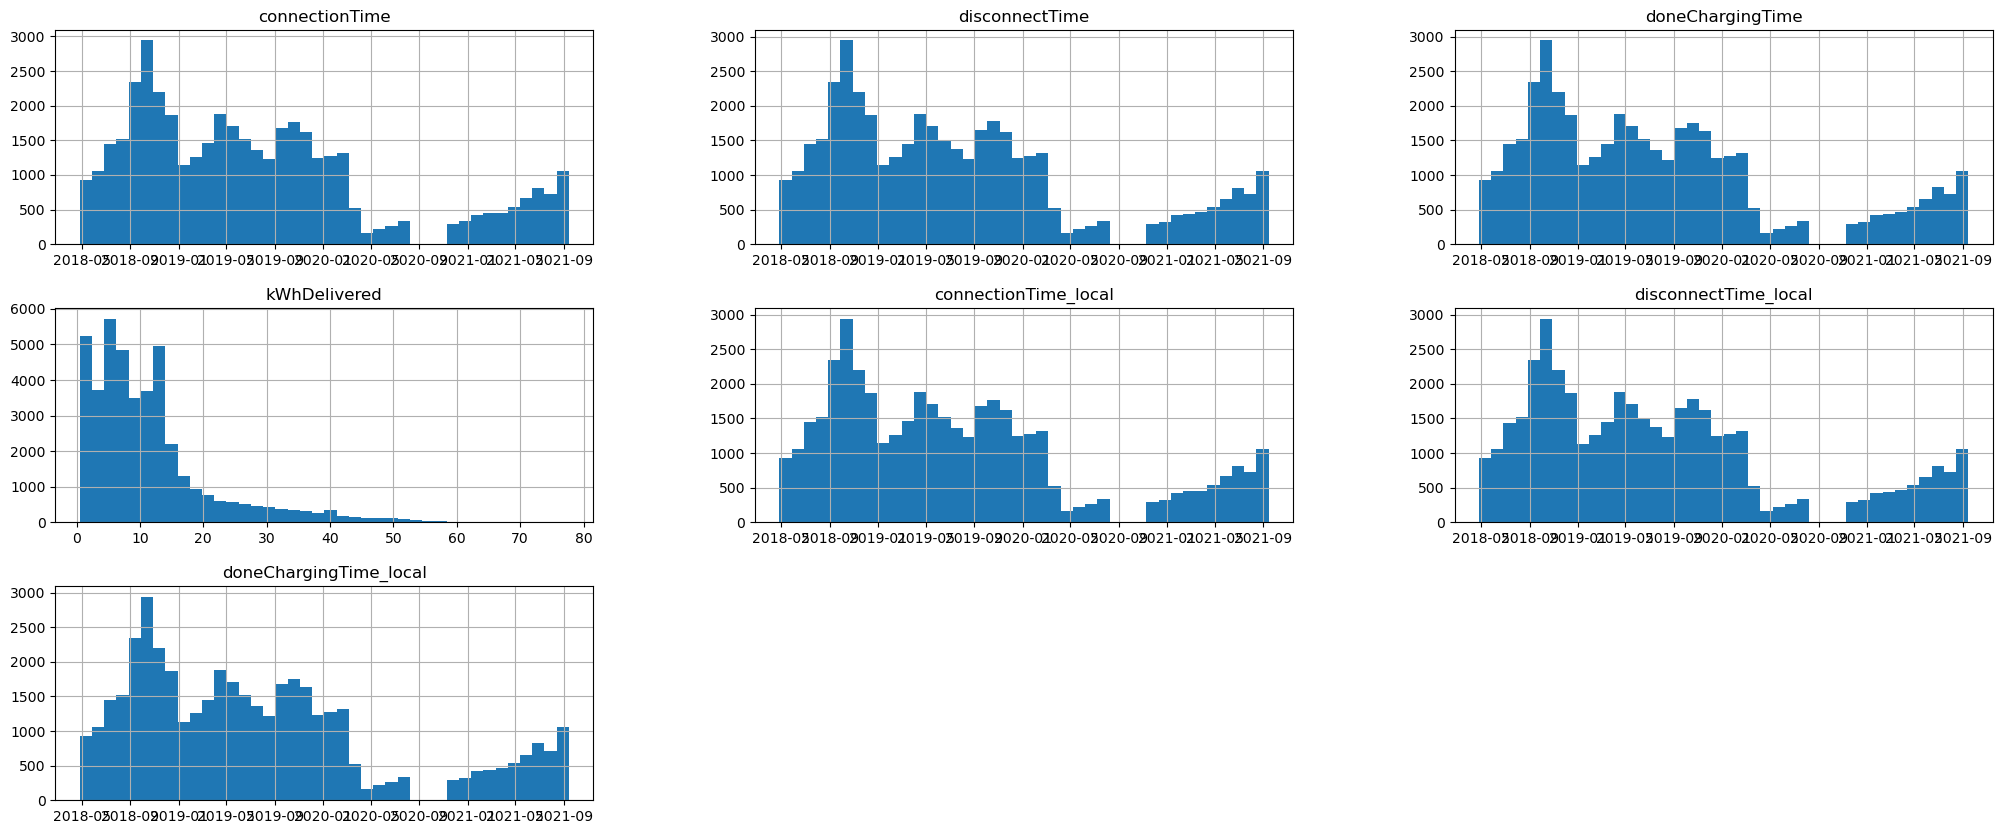

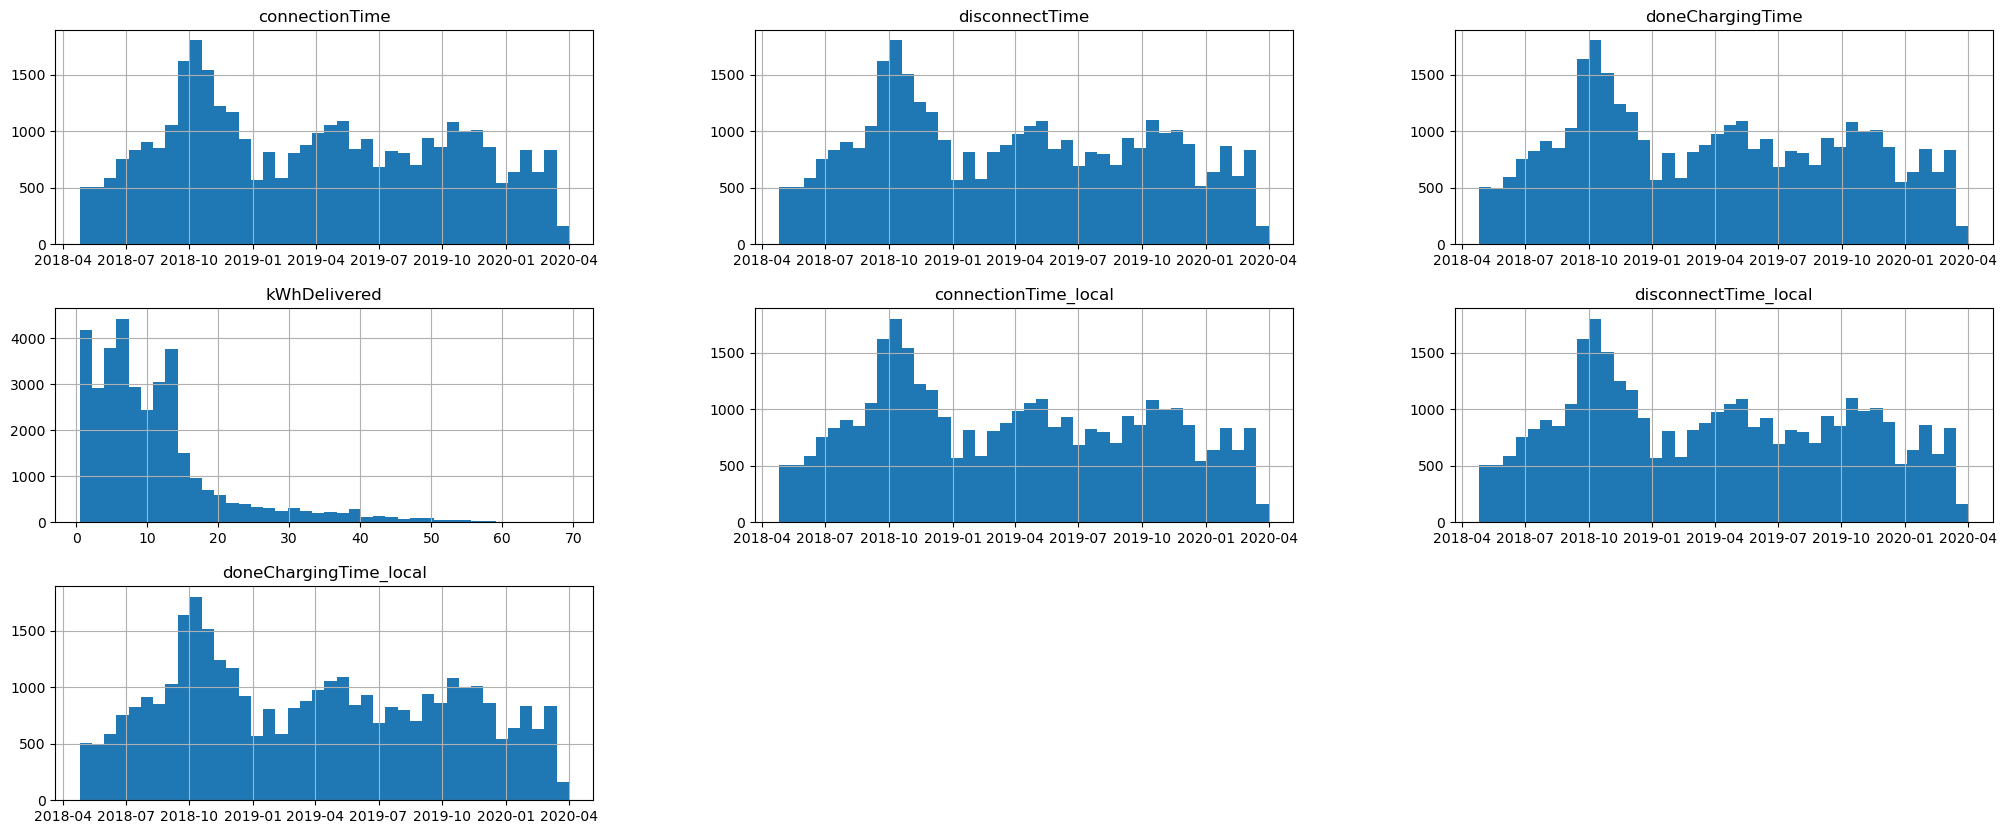

In [33]:
# Check that all data lies around the same year span

# Plot the orginal data
charging_sessions_data.hist(bins=40, figsize=(25,10))
# We have decided to delete the data from 1 April 2020, as there are unusually few loans (April 2020 to September 2021) or even no data at all in between (September 2020 to January 2021).
# To avoid distortions, the data records will be deleted from 1 April 2020. Further analysis of the data is sufficient, as there are still enough data records available.

# Create a datetime object for April 1, 2020
cutoff_date = datetime.datetime(2020, 4, 1).replace(tzinfo=datetime.timezone.utc) # converted object cutoff in the same format as datetime64[ns, UTC]
# Keep only rows where the connectionTime is before the cutoff_date
charging_sessions_data = charging_sessions_data[charging_sessions_data['connectionTime'] < cutoff_date]
# The filtering condition (< cutoff_date) already ensures that both connectionTime and disconnectTime are before May 1st, 2020 (UTC)
# Show the plots
charging_sessions_data.hist(bins=40, figsize=(25,10))

#### 1.3. Add missing attributes

In [34]:
# let's convert user inputs in to list of dictionaries that we can access
def convertStringToList(data_string):
    # after removing missing values we wouldnt need this
    if pd.isna(data_string):
        return
# convert the string to a list (array)
    try:
        result = ast.literal_eval(data_string)
        return result
    except (ValueError, SyntaxError):
        return

# apply the funuction to all rows of userInputs
charging_sessions_data.userInputs = charging_sessions_data.userInputs.apply(lambda x: convertStringToList(x), 0)

def createUserInputColumn(columnName):
    charging_sessions_data[columnName] = None


createUserInputColumn("WhPerMile")
createUserInputColumn("kWhRequested")
createUserInputColumn("milesRequested")
createUserInputColumn("minutesAvailable")
createUserInputColumn("requestedDeparture")


def writeUserInput(input, columnName) :
     # we only consider the last user input
    if  isinstance(input,list) == False:
        return
    count = len(input) - 1 
    return input[count][columnName]

charging_sessions_data.WhPerMile = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'WhPerMile'), 0)
charging_sessions_data.kWhRequested = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'kWhRequested'), 0)
charging_sessions_data.milesRequested = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'milesRequested'), 0)
charging_sessions_data.minutesAvailable = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'minutesAvailable'), 0)
charging_sessions_data.requestedDeparture = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'requestedDeparture'), 0)
# create a new table
user_input_table = charging_sessions_data[['userID', 'WhPerMile', 'kWhRequested','milesRequested','minutesAvailable','requestedDeparture']]

user_input_table.dtypes
user_input_table['requestedDeparture'] = pd.to_datetime(user_input_table['requestedDeparture']).copy()
user_input_table.head()

# fill up the null userInputs with empty list
charging_sessions_data['userInputs'] = charging_sessions_data['userInputs'].apply(
    lambda x: x if isinstance(x, list) else []
)

print(charging_sessions_data['userInputs'].isnull().sum())

# charging_sessions_data.drop(['WhPerMile', 'kWhRequested','milesRequested','minutesAvailable','requestedDeparture', 'userInputs'], axis = 1)


C:\Users\User\AppData\Local\Temp\ipykernel_2076\3022877889.py:14: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  charging_sessions_data.userInputs = charging_sessions_data.userInputs.apply(lambda x: convertStringToList(x), 0)
C:\Users\User\AppData\Local\Temp\ipykernel_2076\3022877889.py:34: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  charging_sessions_data.WhPerMile = charging_sessions_data.userInputs.apply(lambda x : writeUserInput(x, 'WhPerMile'), 0)
C:\Users\User\AppData\Local\Temp\ipykernel_2076\3022877889.py:35: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  charging_sessions_data.kWhRe

0


C:\Users\User\AppData\Local\Temp\ipykernel_2076\3022877889.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_input_table['requestedDeparture'] = pd.to_datetime(user_input_table['requestedDeparture']).copy()


In [35]:
# convert new attributes into their right format
charging_sessions_data['WhPerMile'] = charging_sessions_data['WhPerMile'].astype("float")
charging_sessions_data['kWhRequested'] = charging_sessions_data['kWhRequested'].astype("float")
charging_sessions_data['milesRequested'] = charging_sessions_data['milesRequested'].astype("float")
charging_sessions_data['minutesAvailable'] = charging_sessions_data['minutesAvailable'].astype("float")
charging_sessions_data['requestedDeparture'] = pd.to_datetime(charging_sessions_data['requestedDeparture'])

In [36]:
# fill new attributes null values with 0
charging_sessions_data['WhPerMile'] = charging_sessions_data['WhPerMile'].fillna(0)
charging_sessions_data['kWhRequested'] = charging_sessions_data['kWhRequested'].fillna(0)
charging_sessions_data['milesRequested'] = charging_sessions_data['milesRequested'].fillna(0)
charging_sessions_data['minutesAvailable'] = charging_sessions_data['minutesAvailable'].fillna(0)
# charging_sessions_data['requestedDeparture'] = charging_sessions_data['requestedDeparture'].fillna(0)

In [37]:
charging_sessions_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35228 entries, 3 to 8674
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype                              
---  ------                  --------------  -----                              
 0   id                      35228 non-null  string                             
 1   connectionTime          35228 non-null  datetime64[ns, UTC]                
 2   disconnectTime          35228 non-null  datetime64[ns, UTC]                
 3   doneChargingTime        35228 non-null  datetime64[ns, UTC]                
 4   kWhDelivered            35228 non-null  float64                            
 5   sessionID               35228 non-null  string                             
 6   siteID                  35228 non-null  string                             
 7   spaceID                 35228 non-null  string                             
 8   stationID               35228 non-null  string                             
 9   t

In [38]:
charging_sessions_data.head(5)

,id,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,timezone,userID,userInputs,connectionTime_local,disconnectTime_local,doneChargingTime_local,WhPerMile,kWhRequested,milesRequested,minutesAvailable,requestedDeparture
3,5e23b149f9af8b5fe4b973d2,2020-01-02 13:59:58+00:00,2020-01-02 16:38:39+00:00,2020-01-02 15:18:45+00:00,2.355,1_1_193_820_2020-01-02 13:59:58.309319,1,AG-1F04,1-1-193-820,America/Los_Angeles,1117.0,"[{'WhPerMile': 400, 'kWhRequested': 8.0, 'mile...",2020-01-02 05:59:58-08:00,2020-01-02 08:38:39-08:00,2020-01-02 07:18:45-08:00,400.0,8.00,20.0,65.0,2020-01-02 15:04:58
5,5e23b149f9af8b5fe4b973d4,2020-01-02 14:00:13+00:00,2020-01-02 23:00:41+00:00,2020-01-02 20:13:21+00:00,13.370,1_1_194_821_2020-01-02 14:00:05.241573,1,AG-1F13,1-1-194-821,America/Los_Angeles,3519.0,"[{'WhPerMile': 600, 'kWhRequested': 24.0, 'mil...",2020-01-02 06:00:13-08:00,2020-01-02 15:00:41-08:00,2020-01-02 12:13:21-08:00,600.0,24.00,40.0,624.0,2020-01-03 00:24:13
6,5e23b149f9af8b5fe4b973d5,2020-01-02 14:09:14+00:00,2020-01-03 01:57:58+00:00,2020-01-03 00:59:21+00:00,43.477,1_1_178_817_2020-01-02 14:09:14.451827,1,AG-1F09,1-1-178-817,America/Los_Angeles,933.0,"[{'WhPerMile': 385, 'kWhRequested': 65.45, 'mi...",2020-01-02 06:09:14-08:00,2020-01-02 17:57:58-08:00,2020-01-02 16:59:21-08:00,385.0,65.45,170.0,647.0,2020-01-03 00:56:14
7,5e23b149f9af8b5fe4b973d6,2020-01-02 14:17:32+00:00,2020-01-03 00:44:54+00:00,2020-01-02 20:22:40+00:00,32.441,1_1_191_804_2020-01-02 14:17:32.329535,1,AG-4F34,1-1-191-804,America/Los_Angeles,3737.0,"[{'WhPerMile': 300, 'kWhRequested': 45.0, 'mil...",2020-01-02 06:17:32-08:00,2020-01-02 16:44:54-08:00,2020-01-02 12:22:40-08:00,300.0,45.00,150.0,126.0,2020-01-02 16:23:32
8,5e23b149f9af8b5fe4b973d7,2020-01-02 14:25:38+00:00,2020-01-02 19:36:05+00:00,2020-01-02 18:38:39+00:00,13.264,1_1_194_826_2020-01-02 14:25:37.578692,1,AG-1F11,1-1-194-826,America/Los_Angeles,419.0,"[{'WhPerMile': 400, 'kWhRequested': 40.0, 'mil...",2020-01-02 06:25:38-08:00,2020-01-02 11:36:05-08:00,2020-01-02 10:38:39-08:00,400.0,40.00,100.0,491.0,2020-01-02 22:36:38


### 1.4. Export Cleaned Data

In [39]:
charging_sessions_data.to_csv('cleaned_data.csv', index=False)
user_input_table.to_csv('registered_user_input.csv', index=False)

### Data Cleaning for Weather Data
1. **Delete irrelevant data**
* Check for irrelevant attributes

2. **Check for appropriate format**
* Check for correct attribute type/ format

3. **Check for erroneous data**
* Check for duplicates
* Check for null values
* Check for outliers

### 2. Airport Weather Data Preparation

In [40]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   city                     29244 non-null  object 
 1   timestamp                29244 non-null  object 
 2   temperature              29219 non-null  float64
 3   cloud_cover              29224 non-null  float64
 4   cloud_cover_description  29224 non-null  object 
 5   pressure                 29236 non-null  float64
 6   windspeed                29158 non-null  float64
 7   precipitation            29244 non-null  float64
 8   felt_temperature         29218 non-null  float64
dtypes: float64(6), object(3)
memory usage: 2.0+ MB


#### 2.1. Check for appropriate format

In [41]:
weather_data.dtypes

city                        object
timestamp                   object
temperature                float64
cloud_cover                float64
cloud_cover_description     object
pressure                   float64
windspeed                  float64
precipitation              float64
felt_temperature           float64
dtype: object

In [42]:
weather_data["city"] = weather_data["city"].astype("string")
weather_data["cloud_cover_description"] = weather_data["cloud_cover_description"].astype("string")
weather_data["timestamp"] = pd.to_datetime(weather_data["timestamp"])

weather_data.dtypes

city                       string[python]
timestamp                  datetime64[ns]
temperature                       float64
cloud_cover                       float64
cloud_cover_description    string[python]
pressure                          float64
windspeed                         float64
precipitation                     float64
felt_temperature                  float64
dtype: object

#### 2.2. Check erroneous data

##### 2.2.1. Check for duplicates

In [43]:
# Check for duplicates
duplicated_lines = weather_data[weather_data.duplicated()]
if duplicated_lines.empty:
    print("No duplicates found")
else: print("Duplicates found")

No duplicates found


##### 2.2.2. Check for null values (in whole lines and also within certain columns)

In [44]:
# Check for null values in lines
lines_only_null_or_nan = (weather_data.isna() | (weather_data == 0)).all(axis=1)

# Check if there are lines that only contain the values '0' or 'NaN'.
if lines_only_null_or_nan.any():
    print("There are lines that only contain the values '0' or 'NaN'.")
else:
    print("There are NO lines that only contain the values '0' or 'NaN'.")

There are NO lines that only contain the values '0' or 'NaN'.


In [45]:
#check if there are no null values anymore
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   city                     29244 non-null  string        
 1   timestamp                29244 non-null  datetime64[ns]
 2   temperature              29219 non-null  float64       
 3   cloud_cover              29224 non-null  float64       
 4   cloud_cover_description  29224 non-null  string        
 5   pressure                 29236 non-null  float64       
 6   windspeed                29158 non-null  float64       
 7   precipitation            29244 non-null  float64       
 8   felt_temperature         29218 non-null  float64       
dtypes: datetime64[ns](1), float64(6), string(2)
memory usage: 2.0 MB


In [46]:
# For control check if there are null values in city
print("City null values:", weather_data['city'].isnull().sum())

# Check if other attributes have null values
print("Temperature null values:",weather_data['temperature'].isnull().sum())

City null values: 0
Temperature null values: 25


There seems to be some null values in the attributes temperature, cloud_cover, cloud_cover_description, pressure, windspeed and felt_temperature

In [47]:
# Fill the missing values with interpolation to preserve context consistency
weather_data['windspeed'] = weather_data['windspeed'].interpolate(method="linear")
weather_data['temperature'] = weather_data['temperature'].interpolate(method="linear")
weather_data['cloud_cover'] = weather_data['cloud_cover'].interpolate(method="linear")
weather_data['pressure'] = weather_data['pressure'].interpolate(method="linear")
weather_data['felt_temperature'] = weather_data['felt_temperature'].interpolate(method="linear")

In [48]:
unique_values = weather_data['cloud_cover_description'].unique()
print(unique_values)

<StringArray>
[                   'Fair',                    'Haze',
           'Partly Cloudy',           'Mostly Cloudy',
                  'Cloudy',                     'Fog',
              'Light Rain',                    'Rain',
              'Heavy Rain',      'Heavy Rain / Windy',
      'Light Rain / Windy',                 'T-Storm',
            'Fair / Windy',          'Cloudy / Windy',
   'Mostly Cloudy / Windy',   'Partly Cloudy / Windy',
 'Thunder in the Vicinity',                 'Thunder',
                      <NA>,                   'Smoke',
 'Light Rain with Thunder',           'Heavy T-Storm',
            'Rain / Windy',            'Blowing Dust']
Length: 24, dtype: string


In [49]:
# Fill missing values in cloud_cover_description with interpolation
cloud_cover_map = {'Fair': 0, 'Haze': 1, 'Partly Cloudy': 2, 'Mostly Cloudy': 3, 'Cloudy': 4, 'Fog': 5, 'Light Rain': 6, 'Rain': 7, 'Heavy Rain': 8
, 'Heavy Rain / Windy': 9, 'Light Rain / Windy': 10, 'T-Storm': 11, 'Fair / Windy': 12, 'Mostly Cloudy / Windy': 13, 'Partly Cloudy / Windy': 14, 'Thunder in the Vicinity': 15,
 'Thunder': 16, 'Smoke': 17, 'Light Rain with Thunder': 18, 'Heavy T-Storm': 19, 'Rain / Windy': 20, 'Cloudy / Windy': 21, 'Blowing Dust': 22}
weather_data['cloud_cover_description_encoded'] = weather_data['cloud_cover_description'].map(cloud_cover_map)
weather_data['cloud_cover_description_encoded'] = weather_data['cloud_cover_description_encoded'].interpolate(method='linear')
reverse_cloud_cover_map = {v: k for k, v in cloud_cover_map.items()}
weather_data['cloud_cover_description'] = weather_data['cloud_cover_description_encoded'].map(reverse_cloud_cover_map)

In [50]:
# Fill still missing values after interpolation with "Unknown"
weather_data['cloud_cover_description'].fillna("Unknown")
cloud_cover_map["Unknown"] = 23
weather_data['cloud_cover_description_encoded'] = weather_data['cloud_cover_description'].map(cloud_cover_map)

In [51]:
#check if there are no null values anymore
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29244 entries, 0 to 29243
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   city                             29244 non-null  string        
 1   timestamp                        29244 non-null  datetime64[ns]
 2   temperature                      29244 non-null  float64       
 3   cloud_cover                      29244 non-null  float64       
 4   cloud_cover_description          29242 non-null  object        
 5   pressure                         29244 non-null  float64       
 6   windspeed                        29244 non-null  float64       
 7   precipitation                    29244 non-null  float64       
 8   felt_temperature                 29244 non-null  float64       
 9   cloud_cover_description_encoded  29242 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(1), string(1)
mem

#### 2.2.3. Check for Outliers

array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'cloud_cover'}>],
       [<Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'precipitation'}>],
       [<Axes: title={'center': 'felt_temperature'}>,
        <Axes: title={'center': 'cloud_cover_description_encoded'}>,
        <Axes: >]], dtype=object)

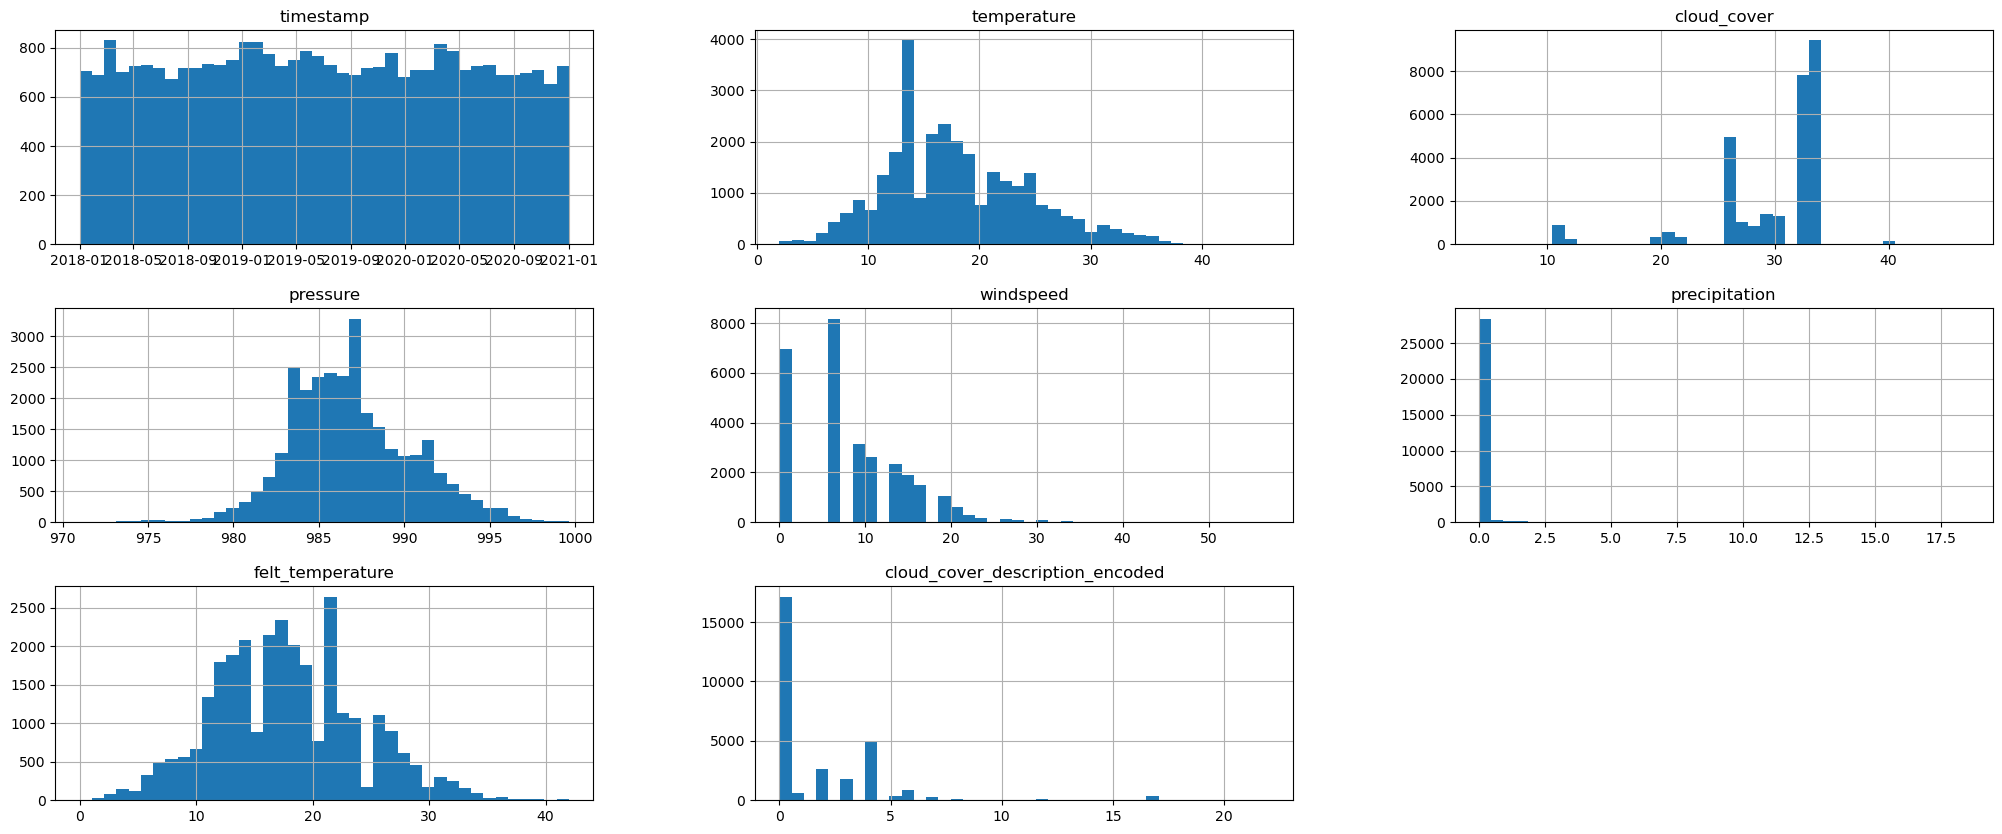

In [52]:
weather_data.hist(bins=40, figsize=(25,10))

There seems to be some outliers for the attributes precipitation and windspeed.

<Axes: >

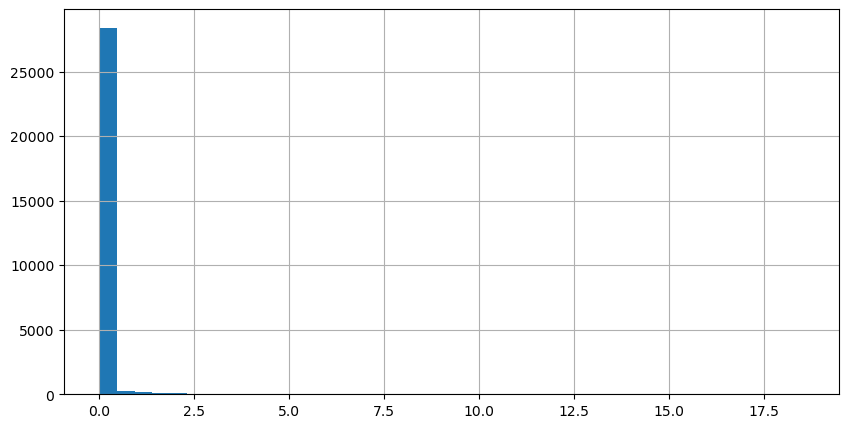

In [53]:
weather_data['precipitation'].hist(bins=40, figsize=(10,5))

In [54]:
print(weather_data[weather_data['precipitation'] > 5.0])

          city           timestamp  temperature  cloud_cover  \
221    Burbank 2018-01-09 14:53:00         12.0         11.0   
236    Burbank 2018-01-09 22:30:00         12.0         40.0   
237    Burbank 2018-01-09 22:53:00         12.0         40.0   
1952   Burbank 2018-03-15 08:41:00         11.0         40.0   
1953   Burbank 2018-03-15 08:46:00         11.0         40.0   
...        ...                 ...          ...          ...   
21518  Burbank 2020-03-12 23:53:00         11.0         12.0   
21519  Burbank 2020-03-13 00:53:00         12.0         12.0   
21847  Burbank 2020-03-23 03:53:00         12.0         12.0   
21853  Burbank 2020-03-23 04:53:00         12.0         12.0   
22375  Burbank 2020-04-10 01:53:00          9.0         11.0   

      cloud_cover_description  pressure  windspeed  precipitation  \
221                Light Rain    978.25        7.0           6.35   
236                Heavy Rain    977.92       15.0           5.08   
237                Heavy

In [55]:
#Remove data if precipitation is > 5.0
weather_data = weather_data[weather_data['precipitation'] <= 5.0]

#check if the outliers are deleted
print(weather_data[weather_data['precipitation'] > 5.0])

Empty DataFrame
Columns: [city, timestamp, temperature, cloud_cover, cloud_cover_description, pressure, windspeed, precipitation, felt_temperature, cloud_cover_description_encoded]
Index: []


<Axes: >

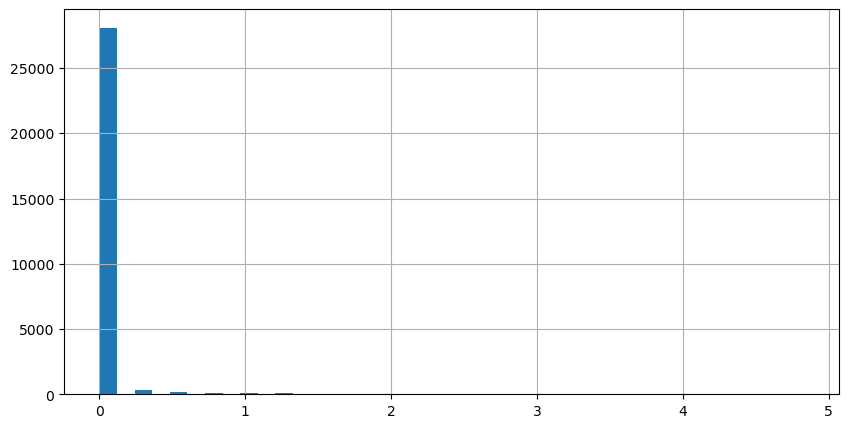

In [56]:
weather_data['precipitation'].hist(bins=40, figsize=(10,5))

<Axes: >

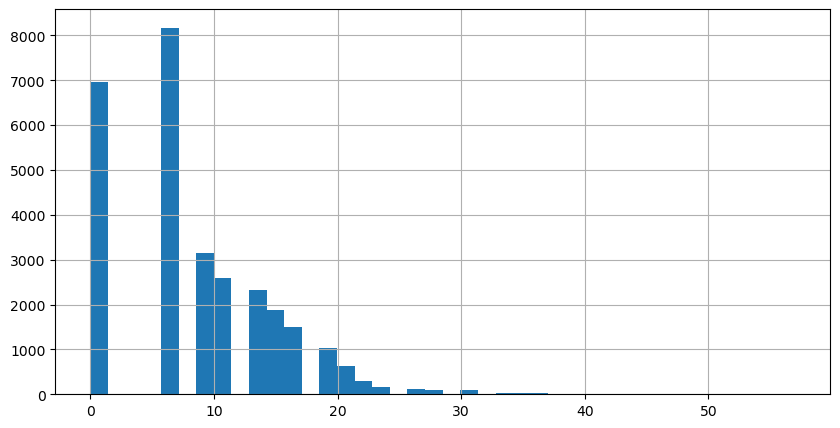

In [57]:
weather_data['windspeed'].hist(bins=40, figsize=(10,5))

In [58]:
print(weather_data[weather_data['windspeed'] > 40])

          city           timestamp  temperature  cloud_cover  \
219    Burbank 2018-01-09 13:53:00         13.0         40.0   
1263   Burbank 2018-02-19 20:53:00         14.0         26.0   
2728   Burbank 2018-04-12 23:53:00         19.0         34.0   
2729   Burbank 2018-04-13 00:53:00         18.0         34.0   
2730   Burbank 2018-04-13 01:53:00         17.0         34.0   
2732   Burbank 2018-04-13 03:53:00         16.0         33.0   
7573   Burbank 2018-10-15 12:53:00         21.0         33.0   
7574   Burbank 2018-10-15 13:53:00         20.0         34.0   
9545   Burbank 2018-12-27 20:53:00         18.0         34.0   
9546   Burbank 2018-12-27 21:53:00         17.0         34.0   
10299  Burbank 2019-01-21 22:53:00         15.0         34.0   
10611  Burbank 2019-02-02 18:08:00         12.0         40.0   
10613  Burbank 2019-02-02 18:58:00         12.0         40.0   
12521  Burbank 2019-04-10 00:53:00         21.0         34.0   
12522  Burbank 2019-04-10 01:53:00      

In [59]:
#Remove data if windspeed is > 40
weather_data = weather_data[weather_data['windspeed'] <= 40]

#check if the outliers are deleted
print(weather_data[weather_data['windspeed'] > 40])

Empty DataFrame
Columns: [city, timestamp, temperature, cloud_cover, cloud_cover_description, pressure, windspeed, precipitation, felt_temperature, cloud_cover_description_encoded]
Index: []


<Axes: >

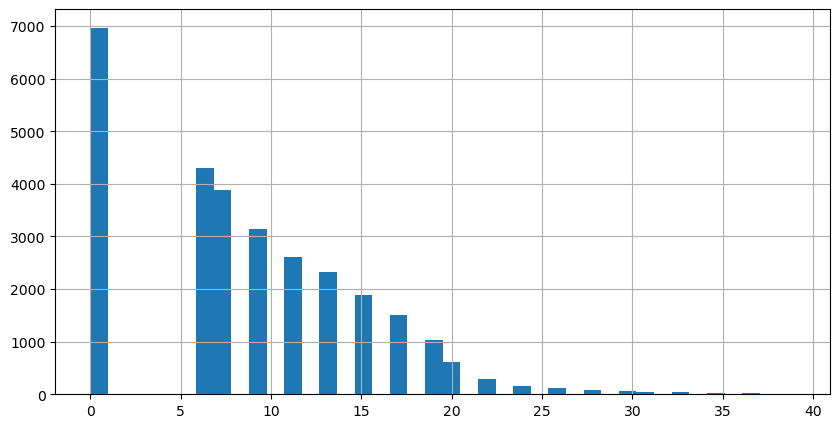

In [60]:
weather_data['windspeed'].hist(bins=40, figsize=(10,5))

<Axes: >

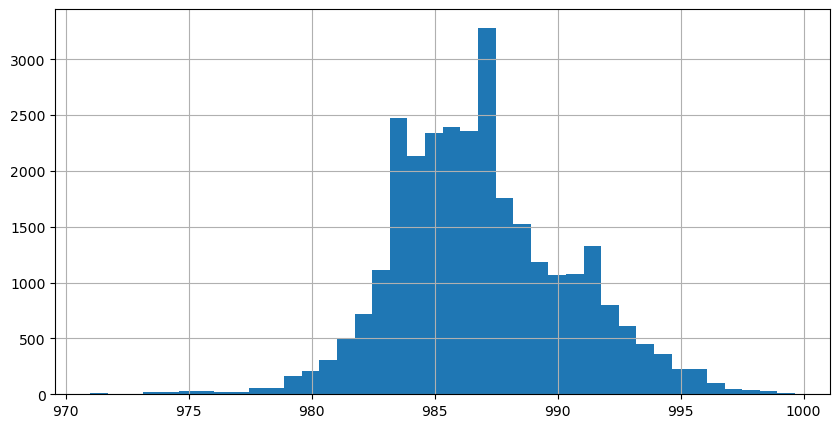

In [61]:
weather_data['pressure'].hist(bins=40, figsize=(10,5))

In [62]:
print(weather_data[weather_data['pressure'] < 800]) # extremely unusual

Empty DataFrame
Columns: [city, timestamp, temperature, cloud_cover, cloud_cover_description, pressure, windspeed, precipitation, felt_temperature, cloud_cover_description_encoded]
Index: []


In [63]:
#Remove data if pressure is < 800
weather_data = weather_data[weather_data['pressure'] >= 800]

#check if the outliers are deleted
print(weather_data[weather_data['pressure'] < 800])

Empty DataFrame
Columns: [city, timestamp, temperature, cloud_cover, cloud_cover_description, pressure, windspeed, precipitation, felt_temperature, cloud_cover_description_encoded]
Index: []


In [64]:
print(weather_data[weather_data['pressure'] > 1100])

Empty DataFrame
Columns: [city, timestamp, temperature, cloud_cover, cloud_cover_description, pressure, windspeed, precipitation, felt_temperature, cloud_cover_description_encoded]
Index: []


<Axes: >

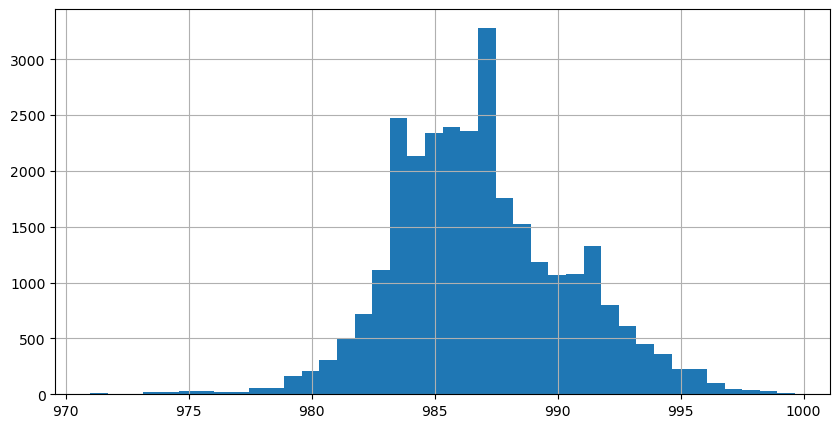

In [65]:
weather_data['pressure'].hist(bins=40, figsize=(10,5))

array([[<Axes: title={'center': 'timestamp'}>,
        <Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'cloud_cover'}>],
       [<Axes: title={'center': 'pressure'}>,
        <Axes: title={'center': 'windspeed'}>,
        <Axes: title={'center': 'precipitation'}>],
       [<Axes: title={'center': 'felt_temperature'}>,
        <Axes: title={'center': 'cloud_cover_description_encoded'}>,
        <Axes: >]], dtype=object)

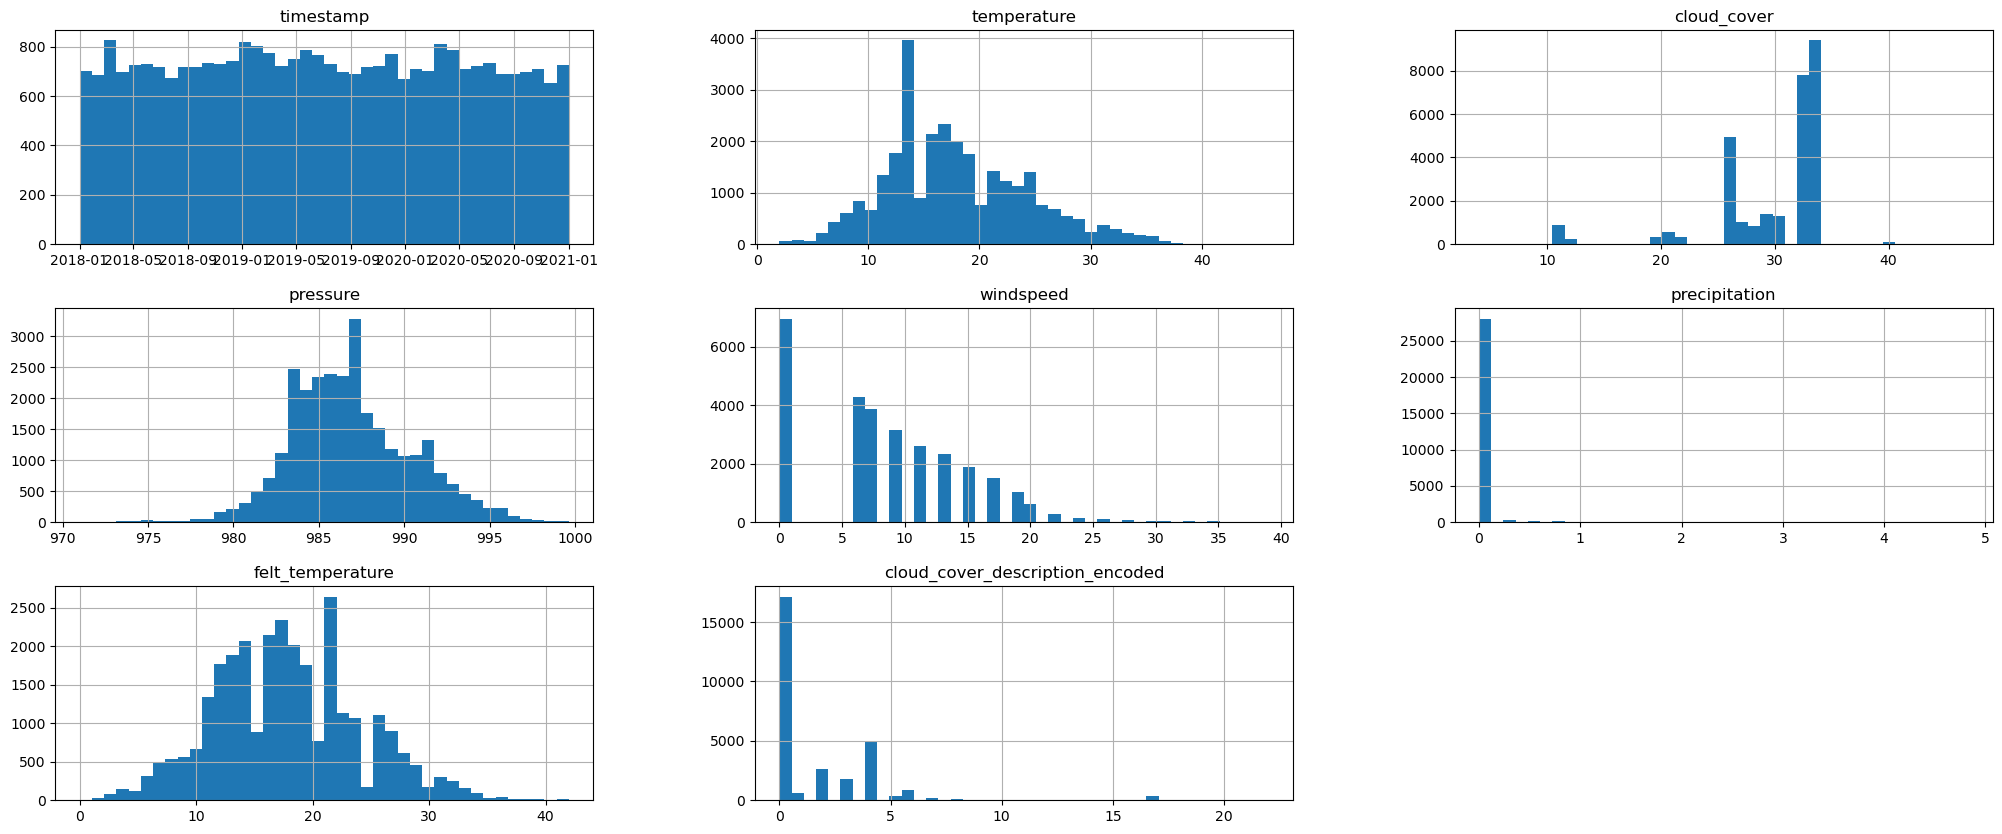

In [66]:
weather_data.hist(bins=40, figsize=(25,10))

### 2.3. Export Cleaned Data

In [67]:
weather_data.to_csv('cleaned_weather_data.csv', index=False)